# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


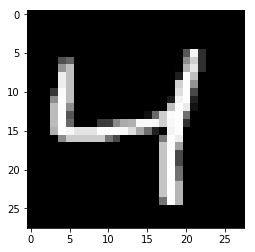

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [4]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, shape=[None,28,28,1])
targets_ = tf.placeholder(tf.float32, shape=[None,28,28,1])

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, [5,5], padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, [5,5], padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, [5,5], padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, 2, 2, padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_images(encoded,[7,7])
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, [5,5], padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_images(conv4, [14,14])
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, [5,5], padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_images(conv5, [28,28])
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, [5,5], padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, [5,5], padding='same')
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [5]:
sess = tf.Session()

In [6]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6828
Epoch: 1/20... Training loss: 0.6701
Epoch: 1/20... Training loss: 0.6497
Epoch: 1/20... Training loss: 0.6215
Epoch: 1/20... Training loss: 0.5831
Epoch: 1/20... Training loss: 0.5331
Epoch: 1/20... Training loss: 0.5471
Epoch: 1/20... Training loss: 0.4964
Epoch: 1/20... Training loss: 0.4948
Epoch: 1/20... Training loss: 0.5218
Epoch: 1/20... Training loss: 0.5006
Epoch: 1/20... Training loss: 0.4637
Epoch: 1/20... Training loss: 0.4535
Epoch: 1/20... Training loss: 0.4468
Epoch: 1/20... Training loss: 0.4393
Epoch: 1/20... Training loss: 0.4125
Epoch: 1/20... Training loss: 0.4008
Epoch: 1/20... Training loss: 0.3877
Epoch: 1/20... Training loss: 0.4128
Epoch: 1/20... Training loss: 0.3655
Epoch: 1/20... Training loss: 0.3551
Epoch: 1/20... Training loss: 0.3449
Epoch: 1/20... Training loss: 0.3481
Epoch: 1/20... Training loss: 0.3677
Epoch: 1/20... Training loss: 0.3405
Epoch: 1/20... Training loss: 0.3254
Epoch: 1/20... Training loss: 0.3210
E

Epoch: 1/20... Training loss: 0.1607
Epoch: 1/20... Training loss: 0.1690
Epoch: 1/20... Training loss: 0.1631
Epoch: 1/20... Training loss: 0.1636
Epoch: 1/20... Training loss: 0.1653
Epoch: 1/20... Training loss: 0.1608
Epoch: 1/20... Training loss: 0.1641
Epoch: 1/20... Training loss: 0.1641
Epoch: 1/20... Training loss: 0.1635
Epoch: 1/20... Training loss: 0.1651
Epoch: 1/20... Training loss: 0.1562
Epoch: 1/20... Training loss: 0.1564
Epoch: 1/20... Training loss: 0.1648
Epoch: 1/20... Training loss: 0.1682
Epoch: 1/20... Training loss: 0.1567
Epoch: 1/20... Training loss: 0.1565
Epoch: 1/20... Training loss: 0.1624
Epoch: 1/20... Training loss: 0.1622
Epoch: 1/20... Training loss: 0.1648
Epoch: 1/20... Training loss: 0.1540
Epoch: 1/20... Training loss: 0.1686
Epoch: 1/20... Training loss: 0.1591
Epoch: 1/20... Training loss: 0.1636
Epoch: 1/20... Training loss: 0.1640
Epoch: 1/20... Training loss: 0.1548
Epoch: 1/20... Training loss: 0.1504
Epoch: 1/20... Training loss: 0.1625
E

Epoch: 2/20... Training loss: 0.1277
Epoch: 2/20... Training loss: 0.1299
Epoch: 2/20... Training loss: 0.1299
Epoch: 2/20... Training loss: 0.1316
Epoch: 2/20... Training loss: 0.1278
Epoch: 2/20... Training loss: 0.1340
Epoch: 2/20... Training loss: 0.1337
Epoch: 2/20... Training loss: 0.1385
Epoch: 2/20... Training loss: 0.1360
Epoch: 2/20... Training loss: 0.1328
Epoch: 2/20... Training loss: 0.1345
Epoch: 2/20... Training loss: 0.1357
Epoch: 2/20... Training loss: 0.1329
Epoch: 2/20... Training loss: 0.1337
Epoch: 2/20... Training loss: 0.1286
Epoch: 2/20... Training loss: 0.1302
Epoch: 2/20... Training loss: 0.1289
Epoch: 2/20... Training loss: 0.1325
Epoch: 2/20... Training loss: 0.1396
Epoch: 2/20... Training loss: 0.1295
Epoch: 2/20... Training loss: 0.1306
Epoch: 2/20... Training loss: 0.1357
Epoch: 2/20... Training loss: 0.1316
Epoch: 2/20... Training loss: 0.1328
Epoch: 2/20... Training loss: 0.1332
Epoch: 2/20... Training loss: 0.1321
Epoch: 2/20... Training loss: 0.1344
E

Epoch: 3/20... Training loss: 0.1219
Epoch: 3/20... Training loss: 0.1203
Epoch: 3/20... Training loss: 0.1223
Epoch: 3/20... Training loss: 0.1188
Epoch: 3/20... Training loss: 0.1207
Epoch: 3/20... Training loss: 0.1186
Epoch: 3/20... Training loss: 0.1233
Epoch: 3/20... Training loss: 0.1142
Epoch: 3/20... Training loss: 0.1219
Epoch: 3/20... Training loss: 0.1188
Epoch: 3/20... Training loss: 0.1225
Epoch: 3/20... Training loss: 0.1178
Epoch: 3/20... Training loss: 0.1160
Epoch: 3/20... Training loss: 0.1202
Epoch: 3/20... Training loss: 0.1197
Epoch: 3/20... Training loss: 0.1186
Epoch: 3/20... Training loss: 0.1181
Epoch: 3/20... Training loss: 0.1172
Epoch: 3/20... Training loss: 0.1192
Epoch: 3/20... Training loss: 0.1221
Epoch: 3/20... Training loss: 0.1205
Epoch: 3/20... Training loss: 0.1190
Epoch: 3/20... Training loss: 0.1216
Epoch: 3/20... Training loss: 0.1210
Epoch: 3/20... Training loss: 0.1193
Epoch: 3/20... Training loss: 0.1188
Epoch: 3/20... Training loss: 0.1218
E

Epoch: 4/20... Training loss: 0.1159
Epoch: 4/20... Training loss: 0.1145
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1195
Epoch: 4/20... Training loss: 0.1111
Epoch: 4/20... Training loss: 0.1143
Epoch: 4/20... Training loss: 0.1143
Epoch: 4/20... Training loss: 0.1128
Epoch: 4/20... Training loss: 0.1113
Epoch: 4/20... Training loss: 0.1187
Epoch: 4/20... Training loss: 0.1134
Epoch: 4/20... Training loss: 0.1126
Epoch: 4/20... Training loss: 0.1106
Epoch: 4/20... Training loss: 0.1122
Epoch: 4/20... Training loss: 0.1165
Epoch: 4/20... Training loss: 0.1084
Epoch: 4/20... Training loss: 0.1149
Epoch: 4/20... Training loss: 0.1114
Epoch: 4/20... Training loss: 0.1152
Epoch: 4/20... Training loss: 0.1132
Epoch: 4/20... Training loss: 0.1093
Epoch: 4/20... Training loss: 0.1126
Epoch: 4/20... Training loss: 0.1116
Epoch: 4/20... Training loss: 0.1115
Epoch: 4/20... Training loss: 0.1128
Epoch: 4/20... Training loss: 0.1133
Epoch: 4/20... Training loss: 0.1137
E

Epoch: 4/20... Training loss: 0.1091
Epoch: 4/20... Training loss: 0.1104
Epoch: 4/20... Training loss: 0.1041
Epoch: 4/20... Training loss: 0.1117
Epoch: 4/20... Training loss: 0.1068
Epoch: 4/20... Training loss: 0.1090
Epoch: 4/20... Training loss: 0.1080
Epoch: 4/20... Training loss: 0.1078
Epoch: 4/20... Training loss: 0.1072
Epoch: 4/20... Training loss: 0.1068
Epoch: 4/20... Training loss: 0.1099
Epoch: 4/20... Training loss: 0.1075
Epoch: 4/20... Training loss: 0.1076
Epoch: 4/20... Training loss: 0.1082
Epoch: 4/20... Training loss: 0.1072
Epoch: 4/20... Training loss: 0.1112
Epoch: 4/20... Training loss: 0.1080
Epoch: 4/20... Training loss: 0.1064
Epoch: 4/20... Training loss: 0.1080
Epoch: 4/20... Training loss: 0.1098
Epoch: 4/20... Training loss: 0.1104
Epoch: 4/20... Training loss: 0.1041
Epoch: 4/20... Training loss: 0.1098
Epoch: 4/20... Training loss: 0.1094
Epoch: 4/20... Training loss: 0.1071
Epoch: 4/20... Training loss: 0.1083
Epoch: 4/20... Training loss: 0.1095
E

Epoch: 5/20... Training loss: 0.1049
Epoch: 5/20... Training loss: 0.1045
Epoch: 5/20... Training loss: 0.1046
Epoch: 5/20... Training loss: 0.1060
Epoch: 5/20... Training loss: 0.1060
Epoch: 5/20... Training loss: 0.1003
Epoch: 5/20... Training loss: 0.1047
Epoch: 5/20... Training loss: 0.1060
Epoch: 5/20... Training loss: 0.1049
Epoch: 5/20... Training loss: 0.1018
Epoch: 5/20... Training loss: 0.1011
Epoch: 5/20... Training loss: 0.1079
Epoch: 5/20... Training loss: 0.1081
Epoch: 5/20... Training loss: 0.1011
Epoch: 5/20... Training loss: 0.1050
Epoch: 5/20... Training loss: 0.1013
Epoch: 5/20... Training loss: 0.1086
Epoch: 5/20... Training loss: 0.1043
Epoch: 5/20... Training loss: 0.1081
Epoch: 5/20... Training loss: 0.1069
Epoch: 5/20... Training loss: 0.1100
Epoch: 5/20... Training loss: 0.1081
Epoch: 5/20... Training loss: 0.1031
Epoch: 5/20... Training loss: 0.1053
Epoch: 5/20... Training loss: 0.1043
Epoch: 5/20... Training loss: 0.1018
Epoch: 5/20... Training loss: 0.1045
E

Epoch: 6/20... Training loss: 0.0972
Epoch: 6/20... Training loss: 0.1002
Epoch: 6/20... Training loss: 0.1011
Epoch: 6/20... Training loss: 0.1008
Epoch: 6/20... Training loss: 0.1001
Epoch: 6/20... Training loss: 0.0997
Epoch: 6/20... Training loss: 0.1026
Epoch: 6/20... Training loss: 0.0975
Epoch: 6/20... Training loss: 0.1051
Epoch: 6/20... Training loss: 0.0984
Epoch: 6/20... Training loss: 0.1004
Epoch: 6/20... Training loss: 0.0992
Epoch: 6/20... Training loss: 0.1029
Epoch: 6/20... Training loss: 0.1007
Epoch: 6/20... Training loss: 0.1008
Epoch: 6/20... Training loss: 0.1046
Epoch: 6/20... Training loss: 0.1072
Epoch: 6/20... Training loss: 0.0997
Epoch: 6/20... Training loss: 0.1034
Epoch: 6/20... Training loss: 0.1002
Epoch: 6/20... Training loss: 0.1001
Epoch: 6/20... Training loss: 0.1010
Epoch: 6/20... Training loss: 0.1016
Epoch: 6/20... Training loss: 0.1051
Epoch: 6/20... Training loss: 0.0999
Epoch: 6/20... Training loss: 0.1038
Epoch: 6/20... Training loss: 0.1008
E

Epoch: 7/20... Training loss: 0.1006
Epoch: 7/20... Training loss: 0.0982
Epoch: 7/20... Training loss: 0.0984
Epoch: 7/20... Training loss: 0.0979
Epoch: 7/20... Training loss: 0.0998
Epoch: 7/20... Training loss: 0.1002
Epoch: 7/20... Training loss: 0.1029
Epoch: 7/20... Training loss: 0.1026
Epoch: 7/20... Training loss: 0.1000
Epoch: 7/20... Training loss: 0.1009
Epoch: 7/20... Training loss: 0.0973
Epoch: 7/20... Training loss: 0.1009
Epoch: 7/20... Training loss: 0.1010
Epoch: 7/20... Training loss: 0.0981
Epoch: 7/20... Training loss: 0.1003
Epoch: 7/20... Training loss: 0.0995
Epoch: 7/20... Training loss: 0.1010
Epoch: 7/20... Training loss: 0.1020
Epoch: 7/20... Training loss: 0.1003
Epoch: 7/20... Training loss: 0.0966
Epoch: 7/20... Training loss: 0.0971
Epoch: 7/20... Training loss: 0.0988
Epoch: 7/20... Training loss: 0.0966
Epoch: 7/20... Training loss: 0.1000
Epoch: 7/20... Training loss: 0.0996
Epoch: 7/20... Training loss: 0.0960
Epoch: 7/20... Training loss: 0.1007
E

Epoch: 7/20... Training loss: 0.0982
Epoch: 7/20... Training loss: 0.0983
Epoch: 7/20... Training loss: 0.0989
Epoch: 7/20... Training loss: 0.0979
Epoch: 7/20... Training loss: 0.0963
Epoch: 7/20... Training loss: 0.0972
Epoch: 7/20... Training loss: 0.0976
Epoch: 7/20... Training loss: 0.1038
Epoch: 7/20... Training loss: 0.0983
Epoch: 7/20... Training loss: 0.1000
Epoch: 7/20... Training loss: 0.0975
Epoch: 7/20... Training loss: 0.0979
Epoch: 7/20... Training loss: 0.0963
Epoch: 7/20... Training loss: 0.0971
Epoch: 7/20... Training loss: 0.1005
Epoch: 7/20... Training loss: 0.0978
Epoch: 7/20... Training loss: 0.0963
Epoch: 7/20... Training loss: 0.0939
Epoch: 7/20... Training loss: 0.0989
Epoch: 7/20... Training loss: 0.0980
Epoch: 7/20... Training loss: 0.0972
Epoch: 7/20... Training loss: 0.1019
Epoch: 7/20... Training loss: 0.0996
Epoch: 7/20... Training loss: 0.0998
Epoch: 7/20... Training loss: 0.0958
Epoch: 7/20... Training loss: 0.0999
Epoch: 7/20... Training loss: 0.0959
E

Epoch: 8/20... Training loss: 0.0939
Epoch: 8/20... Training loss: 0.0999
Epoch: 8/20... Training loss: 0.0957
Epoch: 8/20... Training loss: 0.0993
Epoch: 8/20... Training loss: 0.1005
Epoch: 8/20... Training loss: 0.0967
Epoch: 8/20... Training loss: 0.0987
Epoch: 8/20... Training loss: 0.0977
Epoch: 8/20... Training loss: 0.0920
Epoch: 8/20... Training loss: 0.0986
Epoch: 8/20... Training loss: 0.0983
Epoch: 8/20... Training loss: 0.0927
Epoch: 8/20... Training loss: 0.0952
Epoch: 8/20... Training loss: 0.0991
Epoch: 8/20... Training loss: 0.0980
Epoch: 8/20... Training loss: 0.0946
Epoch: 8/20... Training loss: 0.0959
Epoch: 8/20... Training loss: 0.0967
Epoch: 8/20... Training loss: 0.0943
Epoch: 8/20... Training loss: 0.0922
Epoch: 8/20... Training loss: 0.0980
Epoch: 8/20... Training loss: 0.0925
Epoch: 8/20... Training loss: 0.0930
Epoch: 8/20... Training loss: 0.0963
Epoch: 8/20... Training loss: 0.0975
Epoch: 8/20... Training loss: 0.0984
Epoch: 8/20... Training loss: 0.0969
E

Epoch: 9/20... Training loss: 0.0966
Epoch: 9/20... Training loss: 0.0963
Epoch: 9/20... Training loss: 0.0942
Epoch: 9/20... Training loss: 0.0932
Epoch: 9/20... Training loss: 0.0952
Epoch: 9/20... Training loss: 0.0957
Epoch: 9/20... Training loss: 0.0926
Epoch: 9/20... Training loss: 0.0958
Epoch: 9/20... Training loss: 0.0979
Epoch: 9/20... Training loss: 0.0973
Epoch: 9/20... Training loss: 0.0951
Epoch: 9/20... Training loss: 0.0931
Epoch: 9/20... Training loss: 0.0944
Epoch: 9/20... Training loss: 0.0938
Epoch: 9/20... Training loss: 0.0939
Epoch: 9/20... Training loss: 0.0969
Epoch: 9/20... Training loss: 0.0968
Epoch: 9/20... Training loss: 0.0952
Epoch: 9/20... Training loss: 0.0942
Epoch: 9/20... Training loss: 0.0923
Epoch: 9/20... Training loss: 0.0993
Epoch: 9/20... Training loss: 0.0947
Epoch: 9/20... Training loss: 0.0959
Epoch: 9/20... Training loss: 0.0979
Epoch: 9/20... Training loss: 0.0999
Epoch: 9/20... Training loss: 0.0946
Epoch: 9/20... Training loss: 0.0939
E

Epoch: 10/20... Training loss: 0.0937
Epoch: 10/20... Training loss: 0.0950
Epoch: 10/20... Training loss: 0.0985
Epoch: 10/20... Training loss: 0.0918
Epoch: 10/20... Training loss: 0.0940
Epoch: 10/20... Training loss: 0.0960
Epoch: 10/20... Training loss: 0.0922
Epoch: 10/20... Training loss: 0.0919
Epoch: 10/20... Training loss: 0.0945
Epoch: 10/20... Training loss: 0.0913
Epoch: 10/20... Training loss: 0.0950
Epoch: 10/20... Training loss: 0.0950
Epoch: 10/20... Training loss: 0.0938
Epoch: 10/20... Training loss: 0.0931
Epoch: 10/20... Training loss: 0.0938
Epoch: 10/20... Training loss: 0.0924
Epoch: 10/20... Training loss: 0.0957
Epoch: 10/20... Training loss: 0.0913
Epoch: 10/20... Training loss: 0.0935
Epoch: 10/20... Training loss: 0.0965
Epoch: 10/20... Training loss: 0.0898
Epoch: 10/20... Training loss: 0.0968
Epoch: 10/20... Training loss: 0.1011
Epoch: 10/20... Training loss: 0.0917
Epoch: 10/20... Training loss: 0.0905
Epoch: 10/20... Training loss: 0.0963
Epoch: 10/20

Epoch: 10/20... Training loss: 0.0931
Epoch: 10/20... Training loss: 0.0928
Epoch: 10/20... Training loss: 0.0931
Epoch: 10/20... Training loss: 0.0938
Epoch: 10/20... Training loss: 0.0944
Epoch: 10/20... Training loss: 0.0906
Epoch: 10/20... Training loss: 0.0931
Epoch: 10/20... Training loss: 0.0945
Epoch: 10/20... Training loss: 0.0947
Epoch: 10/20... Training loss: 0.0913
Epoch: 10/20... Training loss: 0.0952
Epoch: 10/20... Training loss: 0.0935
Epoch: 10/20... Training loss: 0.0917
Epoch: 10/20... Training loss: 0.0951
Epoch: 10/20... Training loss: 0.0906
Epoch: 10/20... Training loss: 0.0938
Epoch: 10/20... Training loss: 0.0946
Epoch: 10/20... Training loss: 0.0896
Epoch: 10/20... Training loss: 0.0933
Epoch: 10/20... Training loss: 0.0934
Epoch: 10/20... Training loss: 0.0941
Epoch: 10/20... Training loss: 0.0901
Epoch: 10/20... Training loss: 0.0936
Epoch: 10/20... Training loss: 0.0992
Epoch: 10/20... Training loss: 0.0974
Epoch: 10/20... Training loss: 0.0957
Epoch: 10/20

Epoch: 11/20... Training loss: 0.0923
Epoch: 11/20... Training loss: 0.0921
Epoch: 11/20... Training loss: 0.0911
Epoch: 11/20... Training loss: 0.0949
Epoch: 11/20... Training loss: 0.0931
Epoch: 11/20... Training loss: 0.0930
Epoch: 11/20... Training loss: 0.0899
Epoch: 11/20... Training loss: 0.0955
Epoch: 11/20... Training loss: 0.0975
Epoch: 11/20... Training loss: 0.0894
Epoch: 11/20... Training loss: 0.0945
Epoch: 11/20... Training loss: 0.0932
Epoch: 11/20... Training loss: 0.0889
Epoch: 11/20... Training loss: 0.0924
Epoch: 11/20... Training loss: 0.0913
Epoch: 11/20... Training loss: 0.0952
Epoch: 11/20... Training loss: 0.0920
Epoch: 11/20... Training loss: 0.0940
Epoch: 11/20... Training loss: 0.0969
Epoch: 11/20... Training loss: 0.0908
Epoch: 11/20... Training loss: 0.0931
Epoch: 11/20... Training loss: 0.0899
Epoch: 11/20... Training loss: 0.0978
Epoch: 11/20... Training loss: 0.0933
Epoch: 11/20... Training loss: 0.0940
Epoch: 11/20... Training loss: 0.0927
Epoch: 11/20

Epoch: 12/20... Training loss: 0.0918
Epoch: 12/20... Training loss: 0.0916
Epoch: 12/20... Training loss: 0.0897
Epoch: 12/20... Training loss: 0.0932
Epoch: 12/20... Training loss: 0.0919
Epoch: 12/20... Training loss: 0.0925
Epoch: 12/20... Training loss: 0.0873
Epoch: 12/20... Training loss: 0.0906
Epoch: 12/20... Training loss: 0.0923
Epoch: 12/20... Training loss: 0.0902
Epoch: 12/20... Training loss: 0.0908
Epoch: 12/20... Training loss: 0.0913
Epoch: 12/20... Training loss: 0.0893
Epoch: 12/20... Training loss: 0.0914
Epoch: 12/20... Training loss: 0.0940
Epoch: 12/20... Training loss: 0.0929
Epoch: 12/20... Training loss: 0.0968
Epoch: 12/20... Training loss: 0.0924
Epoch: 12/20... Training loss: 0.0902
Epoch: 12/20... Training loss: 0.0946
Epoch: 12/20... Training loss: 0.0926
Epoch: 12/20... Training loss: 0.0941
Epoch: 12/20... Training loss: 0.0936
Epoch: 12/20... Training loss: 0.0929
Epoch: 12/20... Training loss: 0.0902
Epoch: 12/20... Training loss: 0.0903
Epoch: 12/20

Epoch: 12/20... Training loss: 0.0920
Epoch: 12/20... Training loss: 0.0940
Epoch: 12/20... Training loss: 0.0923
Epoch: 12/20... Training loss: 0.0874
Epoch: 12/20... Training loss: 0.0917
Epoch: 12/20... Training loss: 0.0885
Epoch: 12/20... Training loss: 0.0887
Epoch: 12/20... Training loss: 0.0906
Epoch: 12/20... Training loss: 0.0898
Epoch: 12/20... Training loss: 0.0900
Epoch: 12/20... Training loss: 0.0855
Epoch: 12/20... Training loss: 0.0908
Epoch: 12/20... Training loss: 0.0906
Epoch: 12/20... Training loss: 0.0916
Epoch: 12/20... Training loss: 0.0878
Epoch: 12/20... Training loss: 0.0884
Epoch: 12/20... Training loss: 0.0877
Epoch: 12/20... Training loss: 0.0895
Epoch: 12/20... Training loss: 0.0915
Epoch: 12/20... Training loss: 0.0922
Epoch: 13/20... Training loss: 0.0895
Epoch: 13/20... Training loss: 0.0924
Epoch: 13/20... Training loss: 0.0956
Epoch: 13/20... Training loss: 0.0892
Epoch: 13/20... Training loss: 0.0903
Epoch: 13/20... Training loss: 0.0926
Epoch: 13/20

Epoch: 13/20... Training loss: 0.0909
Epoch: 13/20... Training loss: 0.0896
Epoch: 13/20... Training loss: 0.0934
Epoch: 13/20... Training loss: 0.0933
Epoch: 13/20... Training loss: 0.0913
Epoch: 13/20... Training loss: 0.0946
Epoch: 13/20... Training loss: 0.0914
Epoch: 13/20... Training loss: 0.0887
Epoch: 13/20... Training loss: 0.0892
Epoch: 13/20... Training loss: 0.0914
Epoch: 13/20... Training loss: 0.0900
Epoch: 13/20... Training loss: 0.0924
Epoch: 13/20... Training loss: 0.0863
Epoch: 13/20... Training loss: 0.0893
Epoch: 13/20... Training loss: 0.0912
Epoch: 13/20... Training loss: 0.0903
Epoch: 13/20... Training loss: 0.0895
Epoch: 13/20... Training loss: 0.0869
Epoch: 13/20... Training loss: 0.0901
Epoch: 13/20... Training loss: 0.0889
Epoch: 13/20... Training loss: 0.0909
Epoch: 13/20... Training loss: 0.0866
Epoch: 13/20... Training loss: 0.0940
Epoch: 13/20... Training loss: 0.0933
Epoch: 13/20... Training loss: 0.0912
Epoch: 13/20... Training loss: 0.0915
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0921
Epoch: 14/20... Training loss: 0.0895
Epoch: 14/20... Training loss: 0.0924
Epoch: 14/20... Training loss: 0.0895
Epoch: 14/20... Training loss: 0.0907
Epoch: 14/20... Training loss: 0.0908
Epoch: 14/20... Training loss: 0.0900
Epoch: 14/20... Training loss: 0.0914
Epoch: 14/20... Training loss: 0.0895
Epoch: 14/20... Training loss: 0.0893
Epoch: 14/20... Training loss: 0.0916
Epoch: 14/20... Training loss: 0.0900
Epoch: 14/20... Training loss: 0.0876
Epoch: 14/20... Training loss: 0.0897
Epoch: 14/20... Training loss: 0.0883
Epoch: 14/20... Training loss: 0.0870
Epoch: 14/20... Training loss: 0.0914
Epoch: 14/20... Training loss: 0.0881
Epoch: 14/20... Training loss: 0.0876
Epoch: 14/20... Training loss: 0.0894
Epoch: 14/20... Training loss: 0.0884
Epoch: 14/20... Training loss: 0.0882
Epoch: 14/20... Training loss: 0.0858
Epoch: 14/20... Training loss: 0.0890
Epoch: 14/20... Training loss: 0.0897
Epoch: 14/20... Training loss: 0.0878
Epoch: 14/20

Epoch: 15/20... Training loss: 0.0893
Epoch: 15/20... Training loss: 0.0919
Epoch: 15/20... Training loss: 0.0907
Epoch: 15/20... Training loss: 0.0913
Epoch: 15/20... Training loss: 0.0852
Epoch: 15/20... Training loss: 0.0897
Epoch: 15/20... Training loss: 0.0896
Epoch: 15/20... Training loss: 0.0937
Epoch: 15/20... Training loss: 0.0861
Epoch: 15/20... Training loss: 0.0870
Epoch: 15/20... Training loss: 0.0877
Epoch: 15/20... Training loss: 0.0884
Epoch: 15/20... Training loss: 0.0901
Epoch: 15/20... Training loss: 0.0865
Epoch: 15/20... Training loss: 0.0870
Epoch: 15/20... Training loss: 0.0874
Epoch: 15/20... Training loss: 0.0876
Epoch: 15/20... Training loss: 0.0863
Epoch: 15/20... Training loss: 0.0916
Epoch: 15/20... Training loss: 0.0921
Epoch: 15/20... Training loss: 0.0887
Epoch: 15/20... Training loss: 0.0886
Epoch: 15/20... Training loss: 0.0901
Epoch: 15/20... Training loss: 0.0880
Epoch: 15/20... Training loss: 0.0894
Epoch: 15/20... Training loss: 0.0916
Epoch: 15/20

Epoch: 15/20... Training loss: 0.0904
Epoch: 15/20... Training loss: 0.0900
Epoch: 15/20... Training loss: 0.0913
Epoch: 15/20... Training loss: 0.0864
Epoch: 15/20... Training loss: 0.0872
Epoch: 15/20... Training loss: 0.0919
Epoch: 15/20... Training loss: 0.0877
Epoch: 15/20... Training loss: 0.0889
Epoch: 15/20... Training loss: 0.0910
Epoch: 15/20... Training loss: 0.0888
Epoch: 15/20... Training loss: 0.0892
Epoch: 15/20... Training loss: 0.0864
Epoch: 15/20... Training loss: 0.0892
Epoch: 15/20... Training loss: 0.0886
Epoch: 15/20... Training loss: 0.0883
Epoch: 15/20... Training loss: 0.0870
Epoch: 15/20... Training loss: 0.0852
Epoch: 15/20... Training loss: 0.0886
Epoch: 15/20... Training loss: 0.0896
Epoch: 15/20... Training loss: 0.0874
Epoch: 15/20... Training loss: 0.0899
Epoch: 15/20... Training loss: 0.0852
Epoch: 15/20... Training loss: 0.0857
Epoch: 15/20... Training loss: 0.0886
Epoch: 15/20... Training loss: 0.0888
Epoch: 15/20... Training loss: 0.0884
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0900
Epoch: 16/20... Training loss: 0.0865
Epoch: 16/20... Training loss: 0.0864
Epoch: 16/20... Training loss: 0.0856
Epoch: 16/20... Training loss: 0.0889
Epoch: 16/20... Training loss: 0.0869
Epoch: 16/20... Training loss: 0.0862
Epoch: 16/20... Training loss: 0.0889
Epoch: 16/20... Training loss: 0.0903
Epoch: 16/20... Training loss: 0.0869
Epoch: 16/20... Training loss: 0.0891
Epoch: 16/20... Training loss: 0.0871
Epoch: 16/20... Training loss: 0.0857
Epoch: 16/20... Training loss: 0.0863
Epoch: 16/20... Training loss: 0.0873
Epoch: 16/20... Training loss: 0.0886
Epoch: 16/20... Training loss: 0.0881
Epoch: 16/20... Training loss: 0.0891
Epoch: 16/20... Training loss: 0.0877
Epoch: 16/20... Training loss: 0.0882
Epoch: 16/20... Training loss: 0.0866
Epoch: 16/20... Training loss: 0.0882
Epoch: 16/20... Training loss: 0.0906
Epoch: 16/20... Training loss: 0.0874
Epoch: 16/20... Training loss: 0.0896
Epoch: 16/20... Training loss: 0.0895
Epoch: 16/20

Epoch: 17/20... Training loss: 0.0860
Epoch: 17/20... Training loss: 0.0849
Epoch: 17/20... Training loss: 0.0889
Epoch: 17/20... Training loss: 0.0889
Epoch: 17/20... Training loss: 0.0848
Epoch: 17/20... Training loss: 0.0872
Epoch: 17/20... Training loss: 0.0869
Epoch: 17/20... Training loss: 0.0851
Epoch: 17/20... Training loss: 0.0847
Epoch: 17/20... Training loss: 0.0882
Epoch: 17/20... Training loss: 0.0875
Epoch: 17/20... Training loss: 0.0832
Epoch: 17/20... Training loss: 0.0891
Epoch: 17/20... Training loss: 0.0898
Epoch: 17/20... Training loss: 0.0865
Epoch: 17/20... Training loss: 0.0837
Epoch: 17/20... Training loss: 0.0869
Epoch: 17/20... Training loss: 0.0890
Epoch: 17/20... Training loss: 0.0894
Epoch: 17/20... Training loss: 0.0864
Epoch: 17/20... Training loss: 0.0855
Epoch: 17/20... Training loss: 0.0868
Epoch: 17/20... Training loss: 0.0857
Epoch: 17/20... Training loss: 0.0886
Epoch: 17/20... Training loss: 0.0860
Epoch: 17/20... Training loss: 0.0901
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0856
Epoch: 18/20... Training loss: 0.0865
Epoch: 18/20... Training loss: 0.0874
Epoch: 18/20... Training loss: 0.0868
Epoch: 18/20... Training loss: 0.0863
Epoch: 18/20... Training loss: 0.0856
Epoch: 18/20... Training loss: 0.0877
Epoch: 18/20... Training loss: 0.0858
Epoch: 18/20... Training loss: 0.0903
Epoch: 18/20... Training loss: 0.0895
Epoch: 18/20... Training loss: 0.0898
Epoch: 18/20... Training loss: 0.0870
Epoch: 18/20... Training loss: 0.0868
Epoch: 18/20... Training loss: 0.0857
Epoch: 18/20... Training loss: 0.0861
Epoch: 18/20... Training loss: 0.0893
Epoch: 18/20... Training loss: 0.0900
Epoch: 18/20... Training loss: 0.0846
Epoch: 18/20... Training loss: 0.0899
Epoch: 18/20... Training loss: 0.0852
Epoch: 18/20... Training loss: 0.0882
Epoch: 18/20... Training loss: 0.0900
Epoch: 18/20... Training loss: 0.0866
Epoch: 18/20... Training loss: 0.0846
Epoch: 18/20... Training loss: 0.0860
Epoch: 18/20... Training loss: 0.0876
Epoch: 18/20

Epoch: 18/20... Training loss: 0.0891
Epoch: 18/20... Training loss: 0.0868
Epoch: 18/20... Training loss: 0.0878
Epoch: 18/20... Training loss: 0.0896
Epoch: 18/20... Training loss: 0.0857
Epoch: 18/20... Training loss: 0.0868
Epoch: 18/20... Training loss: 0.0864
Epoch: 18/20... Training loss: 0.0883
Epoch: 18/20... Training loss: 0.0865
Epoch: 18/20... Training loss: 0.0872
Epoch: 18/20... Training loss: 0.0856
Epoch: 18/20... Training loss: 0.0895
Epoch: 18/20... Training loss: 0.0899
Epoch: 18/20... Training loss: 0.0866
Epoch: 18/20... Training loss: 0.0851
Epoch: 18/20... Training loss: 0.0859
Epoch: 18/20... Training loss: 0.0886
Epoch: 18/20... Training loss: 0.0876
Epoch: 18/20... Training loss: 0.0859
Epoch: 18/20... Training loss: 0.0864
Epoch: 18/20... Training loss: 0.0822
Epoch: 18/20... Training loss: 0.0886
Epoch: 18/20... Training loss: 0.0877
Epoch: 18/20... Training loss: 0.0864
Epoch: 18/20... Training loss: 0.0861
Epoch: 18/20... Training loss: 0.0869
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0885
Epoch: 19/20... Training loss: 0.0879
Epoch: 19/20... Training loss: 0.0868
Epoch: 19/20... Training loss: 0.0828
Epoch: 19/20... Training loss: 0.0892
Epoch: 19/20... Training loss: 0.0852
Epoch: 19/20... Training loss: 0.0878
Epoch: 19/20... Training loss: 0.0894
Epoch: 19/20... Training loss: 0.0880
Epoch: 19/20... Training loss: 0.0875
Epoch: 19/20... Training loss: 0.0887
Epoch: 19/20... Training loss: 0.0855
Epoch: 19/20... Training loss: 0.0876
Epoch: 19/20... Training loss: 0.0845
Epoch: 19/20... Training loss: 0.0872
Epoch: 19/20... Training loss: 0.0841
Epoch: 19/20... Training loss: 0.0861
Epoch: 19/20... Training loss: 0.0853
Epoch: 19/20... Training loss: 0.0835
Epoch: 19/20... Training loss: 0.0834
Epoch: 19/20... Training loss: 0.0897
Epoch: 19/20... Training loss: 0.0894
Epoch: 19/20... Training loss: 0.0870
Epoch: 19/20... Training loss: 0.0854
Epoch: 19/20... Training loss: 0.0839
Epoch: 19/20... Training loss: 0.0870
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0867
Epoch: 20/20... Training loss: 0.0851
Epoch: 20/20... Training loss: 0.0838
Epoch: 20/20... Training loss: 0.0877
Epoch: 20/20... Training loss: 0.0885
Epoch: 20/20... Training loss: 0.0867
Epoch: 20/20... Training loss: 0.0884
Epoch: 20/20... Training loss: 0.0875
Epoch: 20/20... Training loss: 0.0889
Epoch: 20/20... Training loss: 0.0870
Epoch: 20/20... Training loss: 0.0848
Epoch: 20/20... Training loss: 0.0855
Epoch: 20/20... Training loss: 0.0867
Epoch: 20/20... Training loss: 0.0861
Epoch: 20/20... Training loss: 0.0839
Epoch: 20/20... Training loss: 0.0842
Epoch: 20/20... Training loss: 0.0844
Epoch: 20/20... Training loss: 0.0866
Epoch: 20/20... Training loss: 0.0878
Epoch: 20/20... Training loss: 0.0841
Epoch: 20/20... Training loss: 0.0835
Epoch: 20/20... Training loss: 0.0862
Epoch: 20/20... Training loss: 0.0841
Epoch: 20/20... Training loss: 0.0851
Epoch: 20/20... Training loss: 0.0888
Epoch: 20/20... Training loss: 0.0852
Epoch: 20/20

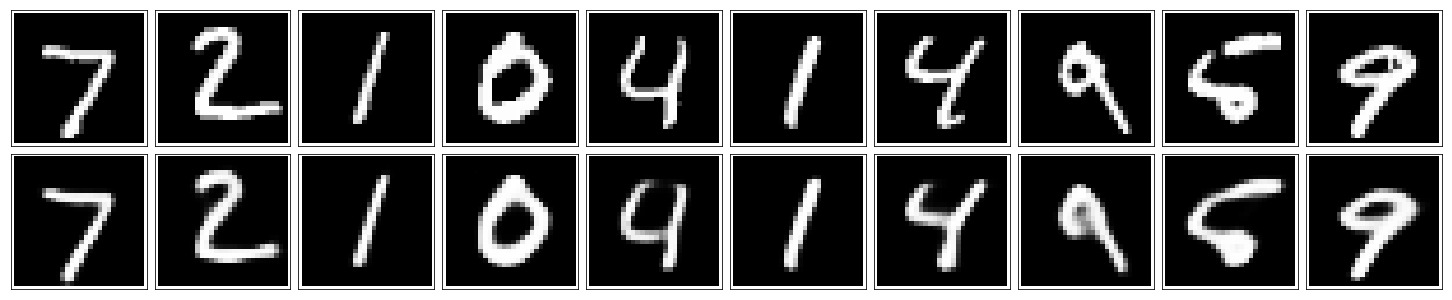

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [19]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [4]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, [5,5], padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, [5,5], padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool1, 16, [5,5], padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, 2, 2, padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_images(encoded, [7,7])
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, [5,5], padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_images(conv4, [14,14])
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, [5,5], padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_images(conv5, [28,28])
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, [5,5], padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, [5,5], padding='same')
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [5]:
sess = tf.Session()

In [22]:
epochs = 20
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.8
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7231
Epoch: 1/20... Training loss: 0.6850
Epoch: 1/20... Training loss: 0.6667
Epoch: 1/20... Training loss: 0.6229
Epoch: 1/20... Training loss: 0.5495
Epoch: 1/20... Training loss: 0.5126
Epoch: 1/20... Training loss: 0.5596
Epoch: 1/20... Training loss: 0.5261
Epoch: 1/20... Training loss: 0.4679
Epoch: 1/20... Training loss: 0.4765
Epoch: 1/20... Training loss: 0.4752
Epoch: 1/20... Training loss: 0.4504
Epoch: 1/20... Training loss: 0.4321
Epoch: 1/20... Training loss: 0.4269
Epoch: 1/20... Training loss: 0.4171
Epoch: 1/20... Training loss: 0.3788
Epoch: 1/20... Training loss: 0.3628
Epoch: 1/20... Training loss: 0.3469
Epoch: 1/20... Training loss: 0.3307
Epoch: 1/20... Training loss: 0.3044
Epoch: 1/20... Training loss: 0.3116
Epoch: 1/20... Training loss: 0.2920
Epoch: 1/20... Training loss: 0.2895
Epoch: 1/20... Training loss: 0.2793
Epoch: 1/20... Training loss: 0.2692
Epoch: 1/20... Training loss: 0.2626
Epoch: 1/20... Training loss: 0.2822
E

Epoch: 1/20... Training loss: 0.1690
Epoch: 1/20... Training loss: 0.1694
Epoch: 1/20... Training loss: 0.1702
Epoch: 1/20... Training loss: 0.1733
Epoch: 1/20... Training loss: 0.1740
Epoch: 1/20... Training loss: 0.1736
Epoch: 1/20... Training loss: 0.1716
Epoch: 1/20... Training loss: 0.1697
Epoch: 1/20... Training loss: 0.1741
Epoch: 1/20... Training loss: 0.1749
Epoch: 1/20... Training loss: 0.1705
Epoch: 1/20... Training loss: 0.1710
Epoch: 1/20... Training loss: 0.1662
Epoch: 1/20... Training loss: 0.1648
Epoch: 1/20... Training loss: 0.1660
Epoch: 1/20... Training loss: 0.1698
Epoch: 1/20... Training loss: 0.1645
Epoch: 1/20... Training loss: 0.1690
Epoch: 1/20... Training loss: 0.1631
Epoch: 1/20... Training loss: 0.1676
Epoch: 1/20... Training loss: 0.1683
Epoch: 1/20... Training loss: 0.1747
Epoch: 1/20... Training loss: 0.1647
Epoch: 1/20... Training loss: 0.1697
Epoch: 1/20... Training loss: 0.1613
Epoch: 1/20... Training loss: 0.1622
Epoch: 1/20... Training loss: 0.1674
E

Epoch: 2/20... Training loss: 0.1507
Epoch: 2/20... Training loss: 0.1540
Epoch: 2/20... Training loss: 0.1560
Epoch: 2/20... Training loss: 0.1546
Epoch: 2/20... Training loss: 0.1478
Epoch: 2/20... Training loss: 0.1511
Epoch: 2/20... Training loss: 0.1543
Epoch: 2/20... Training loss: 0.1531
Epoch: 2/20... Training loss: 0.1481
Epoch: 2/20... Training loss: 0.1539
Epoch: 2/20... Training loss: 0.1542
Epoch: 2/20... Training loss: 0.1535
Epoch: 2/20... Training loss: 0.1500
Epoch: 2/20... Training loss: 0.1523
Epoch: 2/20... Training loss: 0.1536
Epoch: 2/20... Training loss: 0.1484
Epoch: 2/20... Training loss: 0.1485
Epoch: 2/20... Training loss: 0.1525
Epoch: 2/20... Training loss: 0.1507
Epoch: 2/20... Training loss: 0.1531
Epoch: 2/20... Training loss: 0.1468
Epoch: 2/20... Training loss: 0.1476
Epoch: 2/20... Training loss: 0.1489
Epoch: 2/20... Training loss: 0.1509
Epoch: 2/20... Training loss: 0.1498
Epoch: 2/20... Training loss: 0.1489
Epoch: 2/20... Training loss: 0.1530
E

Epoch: 3/20... Training loss: 0.1475
Epoch: 3/20... Training loss: 0.1464
Epoch: 3/20... Training loss: 0.1511
Epoch: 3/20... Training loss: 0.1473
Epoch: 3/20... Training loss: 0.1451
Epoch: 3/20... Training loss: 0.1518
Epoch: 3/20... Training loss: 0.1467
Epoch: 3/20... Training loss: 0.1424
Epoch: 3/20... Training loss: 0.1473
Epoch: 3/20... Training loss: 0.1451
Epoch: 3/20... Training loss: 0.1455
Epoch: 3/20... Training loss: 0.1444
Epoch: 3/20... Training loss: 0.1460
Epoch: 3/20... Training loss: 0.1440
Epoch: 3/20... Training loss: 0.1475
Epoch: 3/20... Training loss: 0.1418
Epoch: 3/20... Training loss: 0.1484
Epoch: 3/20... Training loss: 0.1439
Epoch: 3/20... Training loss: 0.1398
Epoch: 3/20... Training loss: 0.1404
Epoch: 3/20... Training loss: 0.1417
Epoch: 3/20... Training loss: 0.1408
Epoch: 3/20... Training loss: 0.1410
Epoch: 3/20... Training loss: 0.1457
Epoch: 3/20... Training loss: 0.1405
Epoch: 3/20... Training loss: 0.1397
Epoch: 3/20... Training loss: 0.1445
E

Epoch: 3/20... Training loss: 0.1353
Epoch: 3/20... Training loss: 0.1405
Epoch: 3/20... Training loss: 0.1444
Epoch: 3/20... Training loss: 0.1435
Epoch: 3/20... Training loss: 0.1425
Epoch: 3/20... Training loss: 0.1406
Epoch: 3/20... Training loss: 0.1403
Epoch: 3/20... Training loss: 0.1424
Epoch: 3/20... Training loss: 0.1419
Epoch: 3/20... Training loss: 0.1430
Epoch: 3/20... Training loss: 0.1414
Epoch: 3/20... Training loss: 0.1445
Epoch: 4/20... Training loss: 0.1392
Epoch: 4/20... Training loss: 0.1408
Epoch: 4/20... Training loss: 0.1410
Epoch: 4/20... Training loss: 0.1422
Epoch: 4/20... Training loss: 0.1448
Epoch: 4/20... Training loss: 0.1408
Epoch: 4/20... Training loss: 0.1430
Epoch: 4/20... Training loss: 0.1391
Epoch: 4/20... Training loss: 0.1462
Epoch: 4/20... Training loss: 0.1411
Epoch: 4/20... Training loss: 0.1421
Epoch: 4/20... Training loss: 0.1413
Epoch: 4/20... Training loss: 0.1378
Epoch: 4/20... Training loss: 0.1403
Epoch: 4/20... Training loss: 0.1356
E

Epoch: 4/20... Training loss: 0.1447
Epoch: 4/20... Training loss: 0.1382
Epoch: 4/20... Training loss: 0.1397
Epoch: 4/20... Training loss: 0.1400
Epoch: 4/20... Training loss: 0.1420
Epoch: 4/20... Training loss: 0.1393
Epoch: 4/20... Training loss: 0.1420
Epoch: 4/20... Training loss: 0.1412
Epoch: 4/20... Training loss: 0.1455
Epoch: 4/20... Training loss: 0.1412
Epoch: 4/20... Training loss: 0.1453
Epoch: 4/20... Training loss: 0.1413
Epoch: 4/20... Training loss: 0.1422
Epoch: 4/20... Training loss: 0.1396
Epoch: 4/20... Training loss: 0.1399
Epoch: 4/20... Training loss: 0.1406
Epoch: 4/20... Training loss: 0.1406
Epoch: 4/20... Training loss: 0.1418
Epoch: 4/20... Training loss: 0.1354
Epoch: 4/20... Training loss: 0.1371
Epoch: 4/20... Training loss: 0.1402
Epoch: 4/20... Training loss: 0.1455
Epoch: 4/20... Training loss: 0.1413
Epoch: 4/20... Training loss: 0.1360
Epoch: 4/20... Training loss: 0.1390
Epoch: 4/20... Training loss: 0.1438
Epoch: 4/20... Training loss: 0.1399
E

Epoch: 5/20... Training loss: 0.1377
Epoch: 5/20... Training loss: 0.1412
Epoch: 5/20... Training loss: 0.1400
Epoch: 5/20... Training loss: 0.1381
Epoch: 5/20... Training loss: 0.1407
Epoch: 5/20... Training loss: 0.1350
Epoch: 5/20... Training loss: 0.1363
Epoch: 5/20... Training loss: 0.1373
Epoch: 5/20... Training loss: 0.1367
Epoch: 5/20... Training loss: 0.1365
Epoch: 5/20... Training loss: 0.1331
Epoch: 5/20... Training loss: 0.1381
Epoch: 5/20... Training loss: 0.1395
Epoch: 5/20... Training loss: 0.1357
Epoch: 5/20... Training loss: 0.1389
Epoch: 5/20... Training loss: 0.1392
Epoch: 5/20... Training loss: 0.1373
Epoch: 5/20... Training loss: 0.1382
Epoch: 5/20... Training loss: 0.1433
Epoch: 5/20... Training loss: 0.1370
Epoch: 5/20... Training loss: 0.1409
Epoch: 5/20... Training loss: 0.1426
Epoch: 5/20... Training loss: 0.1433
Epoch: 5/20... Training loss: 0.1385
Epoch: 5/20... Training loss: 0.1339
Epoch: 5/20... Training loss: 0.1415
Epoch: 5/20... Training loss: 0.1377
E

Epoch: 6/20... Training loss: 0.1417
Epoch: 6/20... Training loss: 0.1380
Epoch: 6/20... Training loss: 0.1378
Epoch: 6/20... Training loss: 0.1366
Epoch: 6/20... Training loss: 0.1348
Epoch: 6/20... Training loss: 0.1351
Epoch: 6/20... Training loss: 0.1359
Epoch: 6/20... Training loss: 0.1376
Epoch: 6/20... Training loss: 0.1381
Epoch: 6/20... Training loss: 0.1322
Epoch: 6/20... Training loss: 0.1362
Epoch: 6/20... Training loss: 0.1330
Epoch: 6/20... Training loss: 0.1392
Epoch: 6/20... Training loss: 0.1390
Epoch: 6/20... Training loss: 0.1409
Epoch: 6/20... Training loss: 0.1348
Epoch: 6/20... Training loss: 0.1399
Epoch: 6/20... Training loss: 0.1371
Epoch: 6/20... Training loss: 0.1396
Epoch: 6/20... Training loss: 0.1370
Epoch: 6/20... Training loss: 0.1352
Epoch: 6/20... Training loss: 0.1335
Epoch: 6/20... Training loss: 0.1367
Epoch: 6/20... Training loss: 0.1369
Epoch: 6/20... Training loss: 0.1387
Epoch: 6/20... Training loss: 0.1400
Epoch: 6/20... Training loss: 0.1390
E

Epoch: 6/20... Training loss: 0.1366
Epoch: 6/20... Training loss: 0.1366
Epoch: 6/20... Training loss: 0.1363
Epoch: 6/20... Training loss: 0.1370
Epoch: 6/20... Training loss: 0.1401
Epoch: 6/20... Training loss: 0.1383
Epoch: 6/20... Training loss: 0.1337
Epoch: 6/20... Training loss: 0.1345
Epoch: 6/20... Training loss: 0.1353
Epoch: 6/20... Training loss: 0.1357
Epoch: 6/20... Training loss: 0.1337
Epoch: 6/20... Training loss: 0.1408
Epoch: 6/20... Training loss: 0.1338
Epoch: 6/20... Training loss: 0.1367
Epoch: 6/20... Training loss: 0.1376
Epoch: 6/20... Training loss: 0.1406
Epoch: 6/20... Training loss: 0.1336
Epoch: 6/20... Training loss: 0.1361
Epoch: 6/20... Training loss: 0.1366
Epoch: 6/20... Training loss: 0.1328
Epoch: 6/20... Training loss: 0.1329
Epoch: 6/20... Training loss: 0.1344
Epoch: 6/20... Training loss: 0.1366
Epoch: 6/20... Training loss: 0.1383
Epoch: 7/20... Training loss: 0.1359
Epoch: 7/20... Training loss: 0.1328
Epoch: 7/20... Training loss: 0.1361
E

Epoch: 7/20... Training loss: 0.1363
Epoch: 7/20... Training loss: 0.1365
Epoch: 7/20... Training loss: 0.1368
Epoch: 7/20... Training loss: 0.1344
Epoch: 7/20... Training loss: 0.1340
Epoch: 7/20... Training loss: 0.1357
Epoch: 7/20... Training loss: 0.1373
Epoch: 7/20... Training loss: 0.1395
Epoch: 7/20... Training loss: 0.1380
Epoch: 7/20... Training loss: 0.1336
Epoch: 7/20... Training loss: 0.1366
Epoch: 7/20... Training loss: 0.1355
Epoch: 7/20... Training loss: 0.1369
Epoch: 7/20... Training loss: 0.1386
Epoch: 7/20... Training loss: 0.1287
Epoch: 7/20... Training loss: 0.1303
Epoch: 7/20... Training loss: 0.1339
Epoch: 7/20... Training loss: 0.1369
Epoch: 7/20... Training loss: 0.1345
Epoch: 7/20... Training loss: 0.1346
Epoch: 7/20... Training loss: 0.1355
Epoch: 7/20... Training loss: 0.1362
Epoch: 7/20... Training loss: 0.1323
Epoch: 7/20... Training loss: 0.1367
Epoch: 7/20... Training loss: 0.1345
Epoch: 7/20... Training loss: 0.1353
Epoch: 7/20... Training loss: 0.1416
E

Epoch: 8/20... Training loss: 0.1333
Epoch: 8/20... Training loss: 0.1320
Epoch: 8/20... Training loss: 0.1378
Epoch: 8/20... Training loss: 0.1349
Epoch: 8/20... Training loss: 0.1374
Epoch: 8/20... Training loss: 0.1348
Epoch: 8/20... Training loss: 0.1358
Epoch: 8/20... Training loss: 0.1344
Epoch: 8/20... Training loss: 0.1355
Epoch: 8/20... Training loss: 0.1372
Epoch: 8/20... Training loss: 0.1367
Epoch: 8/20... Training loss: 0.1343
Epoch: 8/20... Training loss: 0.1296
Epoch: 8/20... Training loss: 0.1298
Epoch: 8/20... Training loss: 0.1367
Epoch: 8/20... Training loss: 0.1357
Epoch: 8/20... Training loss: 0.1322
Epoch: 8/20... Training loss: 0.1281
Epoch: 8/20... Training loss: 0.1309
Epoch: 8/20... Training loss: 0.1374
Epoch: 8/20... Training loss: 0.1316
Epoch: 8/20... Training loss: 0.1353
Epoch: 8/20... Training loss: 0.1370
Epoch: 8/20... Training loss: 0.1338
Epoch: 8/20... Training loss: 0.1321
Epoch: 8/20... Training loss: 0.1278
Epoch: 8/20... Training loss: 0.1330
E

Epoch: 9/20... Training loss: 0.1374
Epoch: 9/20... Training loss: 0.1334
Epoch: 9/20... Training loss: 0.1388
Epoch: 9/20... Training loss: 0.1333
Epoch: 9/20... Training loss: 0.1343
Epoch: 9/20... Training loss: 0.1359
Epoch: 9/20... Training loss: 0.1377
Epoch: 9/20... Training loss: 0.1353
Epoch: 9/20... Training loss: 0.1311
Epoch: 9/20... Training loss: 0.1324
Epoch: 9/20... Training loss: 0.1303
Epoch: 9/20... Training loss: 0.1309
Epoch: 9/20... Training loss: 0.1313
Epoch: 9/20... Training loss: 0.1364
Epoch: 9/20... Training loss: 0.1302
Epoch: 9/20... Training loss: 0.1326
Epoch: 9/20... Training loss: 0.1307
Epoch: 9/20... Training loss: 0.1358
Epoch: 9/20... Training loss: 0.1375
Epoch: 9/20... Training loss: 0.1288
Epoch: 9/20... Training loss: 0.1343
Epoch: 9/20... Training loss: 0.1308
Epoch: 9/20... Training loss: 0.1325
Epoch: 9/20... Training loss: 0.1318
Epoch: 9/20... Training loss: 0.1358
Epoch: 9/20... Training loss: 0.1286
Epoch: 9/20... Training loss: 0.1353
E

Epoch: 9/20... Training loss: 0.1353
Epoch: 9/20... Training loss: 0.1302
Epoch: 9/20... Training loss: 0.1347
Epoch: 9/20... Training loss: 0.1369
Epoch: 9/20... Training loss: 0.1282
Epoch: 9/20... Training loss: 0.1324
Epoch: 9/20... Training loss: 0.1337
Epoch: 9/20... Training loss: 0.1359
Epoch: 9/20... Training loss: 0.1295
Epoch: 9/20... Training loss: 0.1374
Epoch: 9/20... Training loss: 0.1290
Epoch: 9/20... Training loss: 0.1350
Epoch: 9/20... Training loss: 0.1312
Epoch: 9/20... Training loss: 0.1303
Epoch: 9/20... Training loss: 0.1351
Epoch: 9/20... Training loss: 0.1330
Epoch: 9/20... Training loss: 0.1328
Epoch: 9/20... Training loss: 0.1342
Epoch: 9/20... Training loss: 0.1336
Epoch: 9/20... Training loss: 0.1328
Epoch: 9/20... Training loss: 0.1349
Epoch: 9/20... Training loss: 0.1329
Epoch: 9/20... Training loss: 0.1337
Epoch: 9/20... Training loss: 0.1342
Epoch: 9/20... Training loss: 0.1329
Epoch: 9/20... Training loss: 0.1299
Epoch: 9/20... Training loss: 0.1360
E

Epoch: 10/20... Training loss: 0.1352
Epoch: 10/20... Training loss: 0.1301
Epoch: 10/20... Training loss: 0.1297
Epoch: 10/20... Training loss: 0.1319
Epoch: 10/20... Training loss: 0.1323
Epoch: 10/20... Training loss: 0.1370
Epoch: 10/20... Training loss: 0.1315
Epoch: 10/20... Training loss: 0.1316
Epoch: 10/20... Training loss: 0.1342
Epoch: 10/20... Training loss: 0.1330
Epoch: 10/20... Training loss: 0.1402
Epoch: 10/20... Training loss: 0.1301
Epoch: 10/20... Training loss: 0.1352
Epoch: 10/20... Training loss: 0.1351
Epoch: 10/20... Training loss: 0.1318
Epoch: 10/20... Training loss: 0.1319
Epoch: 10/20... Training loss: 0.1379
Epoch: 10/20... Training loss: 0.1348
Epoch: 10/20... Training loss: 0.1350
Epoch: 10/20... Training loss: 0.1290
Epoch: 10/20... Training loss: 0.1306
Epoch: 10/20... Training loss: 0.1280
Epoch: 10/20... Training loss: 0.1312
Epoch: 10/20... Training loss: 0.1333
Epoch: 10/20... Training loss: 0.1350
Epoch: 10/20... Training loss: 0.1320
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1313
Epoch: 11/20... Training loss: 0.1340
Epoch: 11/20... Training loss: 0.1295
Epoch: 11/20... Training loss: 0.1301
Epoch: 11/20... Training loss: 0.1310
Epoch: 11/20... Training loss: 0.1278
Epoch: 11/20... Training loss: 0.1341
Epoch: 11/20... Training loss: 0.1359
Epoch: 11/20... Training loss: 0.1314
Epoch: 11/20... Training loss: 0.1298
Epoch: 11/20... Training loss: 0.1335
Epoch: 11/20... Training loss: 0.1314
Epoch: 11/20... Training loss: 0.1328
Epoch: 11/20... Training loss: 0.1296
Epoch: 11/20... Training loss: 0.1314
Epoch: 11/20... Training loss: 0.1301
Epoch: 11/20... Training loss: 0.1329
Epoch: 11/20... Training loss: 0.1317
Epoch: 11/20... Training loss: 0.1344
Epoch: 11/20... Training loss: 0.1276
Epoch: 11/20... Training loss: 0.1291
Epoch: 11/20... Training loss: 0.1343
Epoch: 11/20... Training loss: 0.1294
Epoch: 11/20... Training loss: 0.1337
Epoch: 11/20... Training loss: 0.1329
Epoch: 11/20... Training loss: 0.1284
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1360
Epoch: 12/20... Training loss: 0.1317
Epoch: 12/20... Training loss: 0.1268
Epoch: 12/20... Training loss: 0.1297
Epoch: 12/20... Training loss: 0.1281
Epoch: 12/20... Training loss: 0.1333
Epoch: 12/20... Training loss: 0.1327
Epoch: 12/20... Training loss: 0.1324
Epoch: 12/20... Training loss: 0.1308
Epoch: 12/20... Training loss: 0.1312
Epoch: 12/20... Training loss: 0.1336
Epoch: 12/20... Training loss: 0.1311
Epoch: 12/20... Training loss: 0.1333
Epoch: 12/20... Training loss: 0.1322
Epoch: 12/20... Training loss: 0.1297
Epoch: 12/20... Training loss: 0.1311
Epoch: 12/20... Training loss: 0.1312
Epoch: 12/20... Training loss: 0.1309
Epoch: 12/20... Training loss: 0.1332
Epoch: 12/20... Training loss: 0.1362
Epoch: 12/20... Training loss: 0.1327
Epoch: 12/20... Training loss: 0.1334
Epoch: 12/20... Training loss: 0.1309
Epoch: 12/20... Training loss: 0.1327
Epoch: 12/20... Training loss: 0.1304
Epoch: 12/20... Training loss: 0.1337
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1320
Epoch: 12/20... Training loss: 0.1312
Epoch: 12/20... Training loss: 0.1311
Epoch: 12/20... Training loss: 0.1346
Epoch: 12/20... Training loss: 0.1278
Epoch: 12/20... Training loss: 0.1317
Epoch: 12/20... Training loss: 0.1294
Epoch: 12/20... Training loss: 0.1308
Epoch: 12/20... Training loss: 0.1272
Epoch: 12/20... Training loss: 0.1290
Epoch: 12/20... Training loss: 0.1310
Epoch: 12/20... Training loss: 0.1303
Epoch: 12/20... Training loss: 0.1297
Epoch: 12/20... Training loss: 0.1304
Epoch: 12/20... Training loss: 0.1323
Epoch: 12/20... Training loss: 0.1327
Epoch: 12/20... Training loss: 0.1328
Epoch: 12/20... Training loss: 0.1324
Epoch: 12/20... Training loss: 0.1278
Epoch: 12/20... Training loss: 0.1262
Epoch: 12/20... Training loss: 0.1295
Epoch: 12/20... Training loss: 0.1290
Epoch: 12/20... Training loss: 0.1296
Epoch: 12/20... Training loss: 0.1290
Epoch: 12/20... Training loss: 0.1319
Epoch: 12/20... Training loss: 0.1324
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1285
Epoch: 13/20... Training loss: 0.1293
Epoch: 13/20... Training loss: 0.1337
Epoch: 13/20... Training loss: 0.1375
Epoch: 13/20... Training loss: 0.1354
Epoch: 13/20... Training loss: 0.1258
Epoch: 13/20... Training loss: 0.1297
Epoch: 13/20... Training loss: 0.1231
Epoch: 13/20... Training loss: 0.1292
Epoch: 13/20... Training loss: 0.1281
Epoch: 13/20... Training loss: 0.1297
Epoch: 13/20... Training loss: 0.1352
Epoch: 13/20... Training loss: 0.1287
Epoch: 13/20... Training loss: 0.1338
Epoch: 13/20... Training loss: 0.1336
Epoch: 13/20... Training loss: 0.1271
Epoch: 13/20... Training loss: 0.1305
Epoch: 13/20... Training loss: 0.1340
Epoch: 13/20... Training loss: 0.1314
Epoch: 13/20... Training loss: 0.1351
Epoch: 13/20... Training loss: 0.1293
Epoch: 13/20... Training loss: 0.1317
Epoch: 13/20... Training loss: 0.1336
Epoch: 13/20... Training loss: 0.1317
Epoch: 13/20... Training loss: 0.1324
Epoch: 13/20... Training loss: 0.1305
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1328
Epoch: 14/20... Training loss: 0.1293
Epoch: 14/20... Training loss: 0.1315
Epoch: 14/20... Training loss: 0.1310
Epoch: 14/20... Training loss: 0.1281
Epoch: 14/20... Training loss: 0.1300
Epoch: 14/20... Training loss: 0.1273
Epoch: 14/20... Training loss: 0.1312
Epoch: 14/20... Training loss: 0.1332
Epoch: 14/20... Training loss: 0.1286
Epoch: 14/20... Training loss: 0.1208
Epoch: 14/20... Training loss: 0.1313
Epoch: 14/20... Training loss: 0.1255
Epoch: 14/20... Training loss: 0.1305
Epoch: 14/20... Training loss: 0.1282
Epoch: 14/20... Training loss: 0.1276
Epoch: 14/20... Training loss: 0.1302
Epoch: 14/20... Training loss: 0.1259
Epoch: 14/20... Training loss: 0.1319
Epoch: 14/20... Training loss: 0.1286
Epoch: 14/20... Training loss: 0.1303
Epoch: 14/20... Training loss: 0.1272
Epoch: 14/20... Training loss: 0.1326
Epoch: 14/20... Training loss: 0.1346
Epoch: 14/20... Training loss: 0.1304
Epoch: 14/20... Training loss: 0.1282
Epoch: 14/20

Epoch: 14/20... Training loss: 0.1323
Epoch: 14/20... Training loss: 0.1283
Epoch: 14/20... Training loss: 0.1296
Epoch: 14/20... Training loss: 0.1284
Epoch: 14/20... Training loss: 0.1264
Epoch: 14/20... Training loss: 0.1330
Epoch: 14/20... Training loss: 0.1237
Epoch: 14/20... Training loss: 0.1294
Epoch: 14/20... Training loss: 0.1234
Epoch: 14/20... Training loss: 0.1346
Epoch: 14/20... Training loss: 0.1291
Epoch: 14/20... Training loss: 0.1300
Epoch: 14/20... Training loss: 0.1297
Epoch: 14/20... Training loss: 0.1288
Epoch: 14/20... Training loss: 0.1283
Epoch: 14/20... Training loss: 0.1277
Epoch: 14/20... Training loss: 0.1266
Epoch: 14/20... Training loss: 0.1320
Epoch: 14/20... Training loss: 0.1288
Epoch: 14/20... Training loss: 0.1281
Epoch: 14/20... Training loss: 0.1327
Epoch: 15/20... Training loss: 0.1281
Epoch: 15/20... Training loss: 0.1331
Epoch: 15/20... Training loss: 0.1327
Epoch: 15/20... Training loss: 0.1270
Epoch: 15/20... Training loss: 0.1279
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1303
Epoch: 15/20... Training loss: 0.1299
Epoch: 15/20... Training loss: 0.1305
Epoch: 15/20... Training loss: 0.1293
Epoch: 15/20... Training loss: 0.1354
Epoch: 15/20... Training loss: 0.1357
Epoch: 15/20... Training loss: 0.1344
Epoch: 15/20... Training loss: 0.1287
Epoch: 15/20... Training loss: 0.1295
Epoch: 15/20... Training loss: 0.1283
Epoch: 15/20... Training loss: 0.1285
Epoch: 15/20... Training loss: 0.1302
Epoch: 15/20... Training loss: 0.1259
Epoch: 15/20... Training loss: 0.1253
Epoch: 15/20... Training loss: 0.1310
Epoch: 15/20... Training loss: 0.1305
Epoch: 15/20... Training loss: 0.1299
Epoch: 15/20... Training loss: 0.1285
Epoch: 15/20... Training loss: 0.1235
Epoch: 15/20... Training loss: 0.1307
Epoch: 15/20... Training loss: 0.1309
Epoch: 15/20... Training loss: 0.1267
Epoch: 15/20... Training loss: 0.1267
Epoch: 15/20... Training loss: 0.1294
Epoch: 15/20... Training loss: 0.1311
Epoch: 15/20... Training loss: 0.1296
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1319
Epoch: 16/20... Training loss: 0.1306
Epoch: 16/20... Training loss: 0.1300
Epoch: 16/20... Training loss: 0.1269
Epoch: 16/20... Training loss: 0.1310
Epoch: 16/20... Training loss: 0.1294
Epoch: 16/20... Training loss: 0.1278
Epoch: 16/20... Training loss: 0.1325
Epoch: 16/20... Training loss: 0.1329
Epoch: 16/20... Training loss: 0.1289
Epoch: 16/20... Training loss: 0.1323
Epoch: 16/20... Training loss: 0.1336
Epoch: 16/20... Training loss: 0.1274
Epoch: 16/20... Training loss: 0.1304
Epoch: 16/20... Training loss: 0.1328
Epoch: 16/20... Training loss: 0.1300
Epoch: 16/20... Training loss: 0.1295
Epoch: 16/20... Training loss: 0.1260
Epoch: 16/20... Training loss: 0.1319
Epoch: 16/20... Training loss: 0.1268
Epoch: 16/20... Training loss: 0.1291
Epoch: 16/20... Training loss: 0.1313
Epoch: 16/20... Training loss: 0.1293
Epoch: 16/20... Training loss: 0.1276
Epoch: 16/20... Training loss: 0.1272
Epoch: 16/20... Training loss: 0.1288
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1325
Epoch: 17/20... Training loss: 0.1251
Epoch: 17/20... Training loss: 0.1294
Epoch: 17/20... Training loss: 0.1271
Epoch: 17/20... Training loss: 0.1294
Epoch: 17/20... Training loss: 0.1251
Epoch: 17/20... Training loss: 0.1314
Epoch: 17/20... Training loss: 0.1324
Epoch: 17/20... Training loss: 0.1320
Epoch: 17/20... Training loss: 0.1319
Epoch: 17/20... Training loss: 0.1302
Epoch: 17/20... Training loss: 0.1349
Epoch: 17/20... Training loss: 0.1242
Epoch: 17/20... Training loss: 0.1287
Epoch: 17/20... Training loss: 0.1337
Epoch: 17/20... Training loss: 0.1286
Epoch: 17/20... Training loss: 0.1284
Epoch: 17/20... Training loss: 0.1289
Epoch: 17/20... Training loss: 0.1345
Epoch: 17/20... Training loss: 0.1305
Epoch: 17/20... Training loss: 0.1304
Epoch: 17/20... Training loss: 0.1281
Epoch: 17/20... Training loss: 0.1333
Epoch: 17/20... Training loss: 0.1292
Epoch: 17/20... Training loss: 0.1281
Epoch: 17/20... Training loss: 0.1325
Epoch: 17/20

Epoch: 17/20... Training loss: 0.1256
Epoch: 17/20... Training loss: 0.1292
Epoch: 17/20... Training loss: 0.1321
Epoch: 17/20... Training loss: 0.1301
Epoch: 17/20... Training loss: 0.1318
Epoch: 17/20... Training loss: 0.1330
Epoch: 17/20... Training loss: 0.1286
Epoch: 17/20... Training loss: 0.1235
Epoch: 17/20... Training loss: 0.1303
Epoch: 17/20... Training loss: 0.1290
Epoch: 17/20... Training loss: 0.1289
Epoch: 17/20... Training loss: 0.1290
Epoch: 17/20... Training loss: 0.1290
Epoch: 17/20... Training loss: 0.1303
Epoch: 17/20... Training loss: 0.1230
Epoch: 17/20... Training loss: 0.1283
Epoch: 17/20... Training loss: 0.1285
Epoch: 17/20... Training loss: 0.1282
Epoch: 17/20... Training loss: 0.1300
Epoch: 17/20... Training loss: 0.1312
Epoch: 17/20... Training loss: 0.1287
Epoch: 17/20... Training loss: 0.1276
Epoch: 17/20... Training loss: 0.1332
Epoch: 17/20... Training loss: 0.1280
Epoch: 17/20... Training loss: 0.1291
Epoch: 17/20... Training loss: 0.1322
Epoch: 17/20

Epoch: 18/20... Training loss: 0.1271
Epoch: 18/20... Training loss: 0.1328
Epoch: 18/20... Training loss: 0.1246
Epoch: 18/20... Training loss: 0.1275
Epoch: 18/20... Training loss: 0.1273
Epoch: 18/20... Training loss: 0.1267
Epoch: 18/20... Training loss: 0.1290
Epoch: 18/20... Training loss: 0.1281
Epoch: 18/20... Training loss: 0.1294
Epoch: 18/20... Training loss: 0.1275
Epoch: 18/20... Training loss: 0.1247
Epoch: 18/20... Training loss: 0.1315
Epoch: 18/20... Training loss: 0.1294
Epoch: 18/20... Training loss: 0.1328
Epoch: 18/20... Training loss: 0.1317
Epoch: 18/20... Training loss: 0.1290
Epoch: 18/20... Training loss: 0.1272
Epoch: 18/20... Training loss: 0.1265
Epoch: 18/20... Training loss: 0.1313
Epoch: 18/20... Training loss: 0.1265
Epoch: 18/20... Training loss: 0.1312
Epoch: 18/20... Training loss: 0.1279
Epoch: 18/20... Training loss: 0.1305
Epoch: 18/20... Training loss: 0.1303
Epoch: 18/20... Training loss: 0.1302
Epoch: 18/20... Training loss: 0.1313
Epoch: 18/20

Epoch: 19/20... Training loss: 0.1245
Epoch: 19/20... Training loss: 0.1279
Epoch: 19/20... Training loss: 0.1312
Epoch: 19/20... Training loss: 0.1218
Epoch: 19/20... Training loss: 0.1248
Epoch: 19/20... Training loss: 0.1312
Epoch: 19/20... Training loss: 0.1298
Epoch: 19/20... Training loss: 0.1278
Epoch: 19/20... Training loss: 0.1297
Epoch: 19/20... Training loss: 0.1304
Epoch: 19/20... Training loss: 0.1287
Epoch: 19/20... Training loss: 0.1290
Epoch: 19/20... Training loss: 0.1301
Epoch: 19/20... Training loss: 0.1300
Epoch: 19/20... Training loss: 0.1276
Epoch: 19/20... Training loss: 0.1306
Epoch: 19/20... Training loss: 0.1325
Epoch: 19/20... Training loss: 0.1326
Epoch: 19/20... Training loss: 0.1290
Epoch: 19/20... Training loss: 0.1279
Epoch: 19/20... Training loss: 0.1305
Epoch: 19/20... Training loss: 0.1272
Epoch: 19/20... Training loss: 0.1312
Epoch: 19/20... Training loss: 0.1307
Epoch: 19/20... Training loss: 0.1264
Epoch: 19/20... Training loss: 0.1279
Epoch: 19/20

Epoch: 19/20... Training loss: 0.1279
Epoch: 19/20... Training loss: 0.1299
Epoch: 19/20... Training loss: 0.1327
Epoch: 19/20... Training loss: 0.1303
Epoch: 19/20... Training loss: 0.1302
Epoch: 19/20... Training loss: 0.1268
Epoch: 19/20... Training loss: 0.1275
Epoch: 19/20... Training loss: 0.1313
Epoch: 19/20... Training loss: 0.1276
Epoch: 20/20... Training loss: 0.1321
Epoch: 20/20... Training loss: 0.1247
Epoch: 20/20... Training loss: 0.1283
Epoch: 20/20... Training loss: 0.1237
Epoch: 20/20... Training loss: 0.1291
Epoch: 20/20... Training loss: 0.1248
Epoch: 20/20... Training loss: 0.1298
Epoch: 20/20... Training loss: 0.1218
Epoch: 20/20... Training loss: 0.1294
Epoch: 20/20... Training loss: 0.1274
Epoch: 20/20... Training loss: 0.1314
Epoch: 20/20... Training loss: 0.1332
Epoch: 20/20... Training loss: 0.1258
Epoch: 20/20... Training loss: 0.1318
Epoch: 20/20... Training loss: 0.1315
Epoch: 20/20... Training loss: 0.1308
Epoch: 20/20... Training loss: 0.1276
Epoch: 20/20

Epoch: 20/20... Training loss: 0.1284
Epoch: 20/20... Training loss: 0.1267
Epoch: 20/20... Training loss: 0.1267
Epoch: 20/20... Training loss: 0.1285
Epoch: 20/20... Training loss: 0.1270
Epoch: 20/20... Training loss: 0.1283
Epoch: 20/20... Training loss: 0.1278
Epoch: 20/20... Training loss: 0.1293
Epoch: 20/20... Training loss: 0.1310
Epoch: 20/20... Training loss: 0.1281
Epoch: 20/20... Training loss: 0.1242
Epoch: 20/20... Training loss: 0.1255
Epoch: 20/20... Training loss: 0.1231
Epoch: 20/20... Training loss: 0.1284
Epoch: 20/20... Training loss: 0.1344
Epoch: 20/20... Training loss: 0.1263
Epoch: 20/20... Training loss: 0.1337
Epoch: 20/20... Training loss: 0.1284
Epoch: 20/20... Training loss: 0.1293
Epoch: 20/20... Training loss: 0.1294
Epoch: 20/20... Training loss: 0.1295
Epoch: 20/20... Training loss: 0.1291
Epoch: 20/20... Training loss: 0.1280
Epoch: 20/20... Training loss: 0.1262
Epoch: 20/20... Training loss: 0.1318
Epoch: 20/20... Training loss: 0.1256
Epoch: 20/20

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

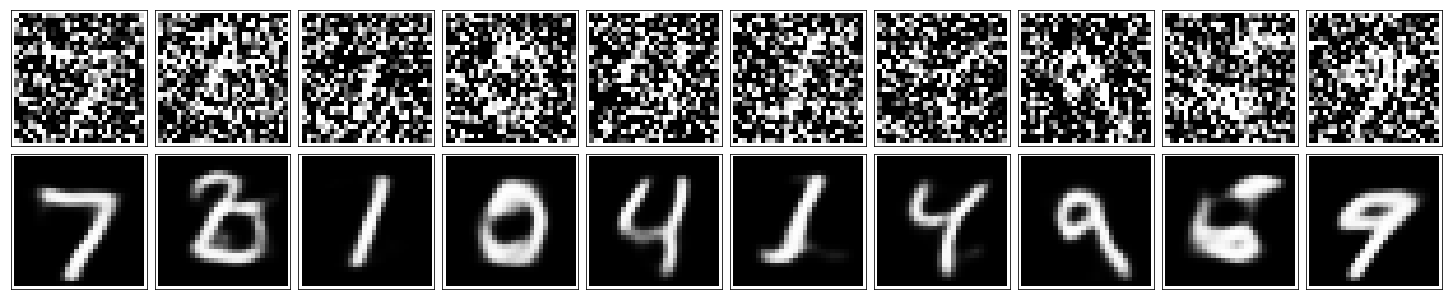

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

### Good！
> I can't reconise the noisy image with a factor of 0.8 myself either